In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

pd.options.display.max_columns = 999

# Washington

## VEST Documentation

Election results and precinct shapefile from the Washington Secretary of State (https://www.sos.wa.gov/elections/research/election-results-and-voters-pamphlets.aspx)

In Kittitas County the votes reported as Ellensburg 28 in the Secretary of State results are actually those of Cle Elum 2. Ellensburg 28 was not a distinct voting precinct for the 2020 general election.

G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Green Party)  
G20PRESLAR - Gloria La Riva (Socialism and Liberation Party)  
G20PRESKEN - Alyson Kennedy (Socialist Workers Party)  
G20PREOWRI - Write-in Votes  

G20GOVDINS - Jay Inslee (Democratic Party)  
G20GOVRCUL - Loren Culp (Republican Party)  
G20GOVOWRI - Write-in Votes  

G20LTGDHEC - Denny Heck (Democratic Party)  
G20LTGDLII - Marko Liias (Democratic Party)  
G20LTGOWRI - Write-in Votes  

G20SOSDTAR - Gael Tarleton (Democratic Party)  
G20SOSRWYM - Kim Wyman (Republican Party)  
G20SOSOWRI - Write-in Votes  

G20TREDPEL - Mike Pellicciotti (Democratic Party)  
G20TRERDAV - Duane A. Davidson (Republican Party)  
G20TREOWRI - Write-in Votes  

G20AUDDMCC - Pat (Patrice) McCarthy (Democratic Party)  
G20AUDRLEY - Chris Leyba (Republican Party)  
G20AUDOWRI - Write-in Votes  

G20ATGDFER - Bob Ferguson (Democratic Party)  
G20ATGRLAR - Matt Larkin (Republican Party)  
G20ATGOWRI - Write-in Votes  

G20LANDFRA - Hilary Franz (Democratic Party)  
G20LANRPED - Sue Kuehl Pederson (Republican Party)  
G20LANOWRI - Write-in Votes  

G20INSDKRE - Mike Freidler (Democratic Party)  
G20INSRPAT - Chirayu Avinash Patel (Republican Party)  
G20INSOWRI - Write-in Votes  

## Load VEST File

In [2]:
vest_wa_20 = gp.read_file("./raw-from-source/VEST/wa_2020/wa_2020.shp")

In [3]:
#Create a list of data columns
data_columns = [col for col in vest_wa_20.columns if "G20" in col]

## Load Election Results

In [4]:
election_results = pd.read_excel("./raw-from-source/Election_Results/2020gen_precinct_results_gis-ready.xlsx")

In [5]:
#Filter down to relevant election results
races_list = ['President/Vice President','Governor',
'Lt. Governor', 'Secretary of State', 'State Treasurer',
'State Auditor', 'Attorney General',
'Commissioner of Public Lands',
 'Insurance Commissioner']

election_results = election_results[election_results["RaceName"].isin(races_list)]

In [6]:
#Create a pivot column
election_results["pivot_col"] = election_results["County"]+"-"+election_results["PrecinctName"].astype(str)

#Create a column w/ cand. name and race to make write-in votes easier to deal with
election_results["cand_detailed"] = election_results["RaceName"]+"-"+election_results["Candidate"]

#Perform the pivot and clean up the column names
election_results_pivot = pd.pivot_table(election_results,index=["pivot_col","PrecinctName","PrecinctCode","County"],columns=["cand_detailed",],values=['Votes'],aggfunc=sum)
election_results_pivot.columns = election_results_pivot.columns.droplevel(0)
election_results_pivot.reset_index(inplace=True,drop=False)

In [7]:
#Make a dictionary to rename the columns
cand_rename_dict = {'Attorney General-Bob Ferguson':'G20ATGDFER',
                    'Attorney General-Matt Larkin':'G20ATGRLAR',
                    'Attorney General-WRITE-IN':'G20ATGOWRI',
                    
       'Commissioner of Public Lands-Hilary Franz':'G20LANDFRA',
       'Commissioner of Public Lands-Sue Kuehl Pederson':'G20LANRPED',
       'Commissioner of Public Lands-WRITE-IN':'G20LANOWRI', 
                    
       'Governor-Jay Inslee':'G20GOVDINS',
       'Governor-Loren Culp':'G20GOVRCUL', 
       'Governor-WRITE-IN':'G20GOVOWRI',
                    
       'Insurance Commissioner-Chirayu Avinash Patel':'G20INSRPAT',
       'Insurance Commissioner-Mike Kreidler':'G20INSDKRE',
       'Insurance Commissioner-WRITE-IN':'G20INSOWRI', 
                    
       'Lt. Governor-Denny Heck':'G20LTGDHEC',
       'Lt. Governor-Marko Liias':'G20LTGDLII', 
       'Lt. Governor-WRITE-IN':'G20LTGOWRI',
        
       'President/Vice President-Alyson Kennedy / Malcolm M. Jarrett':'G20PRESKEN',
       'President/Vice President-Donald J. Trump / Michael R. Pence':'G20PRERTRU',
       'President/Vice President-Gloria La Riva / Sunil Freeman':'G20PRESLAR',
       'President/Vice President-Howie Hawkins / Angela Walker':'G20PREGHAW',
       'President/Vice President-Jo Jorgensen / Jeremy "Spike" Cohen':'G20PRELJOR',
       'President/Vice President-Joseph R. Biden / Kamala D. Harris':'G20PREDBID',
       'President/Vice President-WRITE-IN':'G20PREOWRI',
                    
       'Secretary of State-Gael Tarleton':'G20SOSDTAR',
       'Secretary of State-Kim Wyman':'G20SOSRWYM', 
       'Secretary of State-WRITE-IN':'G20SOSOWRI',
                    
       'State Auditor-Chris Leyba':'G20AUDRLEY', 
       'State Auditor-Pat (Patrice) McCarthy':'G20AUDDMCC',
       'State Auditor-WRITE-IN':'G20AUDOWRI', 
                    
       'State Treasurer-Duane A. Davidson':'G20TRERDAV',
       'State Treasurer-Mike Pellicciotti':'G20TREDPEL', 
       'State Treasurer-WRITE-IN':'G20TREOWRI'}

#Rename the columns
election_results_pivot.rename(columns=cand_rename_dict,inplace=True)

## Statewide Totals Check

In [8]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [9]:
statewide_totals_check(vest_wa_20,election_results_pivot,data_columns)

***Statewide Totals Check***
G20PREDBID is equal 	VEST / RDH: 2369612
G20PRERTRU is equal 	VEST / RDH: 1584651
G20PRELJOR is equal 	VEST / RDH: 80500
G20PREGHAW is equal 	VEST / RDH: 18289
G20PRESLAR is equal 	VEST / RDH: 4840
G20PRESKEN is equal 	VEST / RDH: 2487
G20PREOWRI is equal 	VEST / RDH: 27252
G20GOVDINS is equal 	VEST / RDH: 2294243
G20GOVRCUL is equal 	VEST / RDH: 1749066
G20GOVOWRI is equal 	VEST / RDH: 13145
G20LTGDHEC is equal 	VEST / RDH: 1658405
G20LTGDLII is equal 	VEST / RDH: 1218548
G20LTGOWRI is equal 	VEST / RDH: 759076
G20SOSDTAR is equal 	VEST / RDH: 1826710
G20SOSRWYM is equal 	VEST / RDH: 2116141
G20SOSOWRI is equal 	VEST / RDH: 4666
G20TREDPEL is equal 	VEST / RDH: 2089159
G20TRERDAV is equal 	VEST / RDH: 1818895
G20TREOWRI is equal 	VEST / RDH: 3339
G20AUDDMCC is equal 	VEST / RDH: 2260830
G20AUDRLEY is equal 	VEST / RDH: 1633956
G20AUDOWRI is equal 	VEST / RDH: 3316
G20ATGDFER is equal 	VEST / RDH: 2226418
G20ATGRLAR is equal 	VEST / RDH: 1714927
G20ATGOWRI 

## County-by-County Totals Check

In [10]:
#Make the same county column as VEST
election_results_pivot["COUNTYNAME"] = election_results_pivot["County"]

In [11]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [12]:
county_totals_check(vest_wa_20,election_results_pivot,data_columns,"COUNTYNAME",full_print=False)

***Countywide Totals Check***

G20PREDBID is equal across all counties
G20PRERTRU is equal across all counties
G20PRELJOR is equal across all counties
G20PREGHAW is equal across all counties
G20PRESLAR is equal across all counties
G20PRESKEN is equal across all counties
G20PREOWRI is equal across all counties
G20GOVDINS is equal across all counties
G20GOVRCUL is equal across all counties
G20GOVOWRI is equal across all counties
G20LTGDHEC is equal across all counties
G20LTGDLII is equal across all counties
G20LTGOWRI is equal across all counties
G20SOSDTAR is equal across all counties
G20SOSRWYM is equal across all counties
G20SOSOWRI is equal across all counties
G20TREDPEL is equal across all counties
G20TRERDAV is equal across all counties
G20TREOWRI is equal across all counties
G20AUDDMCC is equal across all counties
G20AUDRLEY is equal across all counties
G20AUDOWRI is equal across all counties
G20ATGDFER is equal across all counties
G20ATGRLAR is equal across all counties
G20ATGOWR

In [13]:
#This was used to check against the official WA file
#vest_wa_20.groupby(["COUNTYNAME"]).sum().to_csv("./county_totals.csv")

## Precinct-by-Precinct Check

In [14]:
#Try to find unique_IDs in both, create a matching "unique_ID" column
election_results_pivot["PrecinctCode"].value_counts(dropna=False)
election_results_pivot["unique_ID"] = election_results_pivot["PrecinctCode"]

vest_wa_20["ST_CODE"].value_counts(dropna=False)
vest_wa_20["unique_ID"] = vest_wa_20["ST_CODE"]

### Processing

From the VEST documentation:

> In Kittitas County the votes reported as Ellensburg 28 in the Secretary of State results are actually those of Cle Elum 2. Ellensburg 28 was not a distinct voting precinct for the 2020 general election.

In [15]:
print(election_results_pivot.loc[election_results_pivot["PrecinctName"]=="CLE ELUM 2"])
print(election_results_pivot.loc[election_results_pivot["PrecinctName"]=="ELLENSBURG 28"])


for i in data_columns:
    num = election_results_pivot.loc[election_results_pivot["PrecinctName"]=="ELLENSBURG 28"][i].iloc[0]
    print(num)
    election_results_pivot.loc[election_results_pivot["PrecinctName"]=="CLE ELUM 2",i] = num
    election_results_pivot.loc[election_results_pivot["PrecinctName"]=="ELLENSBURG 28",i] = 0
    
print(election_results_pivot.loc[election_results_pivot["PrecinctName"]=="CLE ELUM 2"])
print(election_results_pivot.loc[election_results_pivot["PrecinctName"]=="ELLENSBURG 28"])

cand_detailed            pivot_col PrecinctName PrecinctCode    County  \
4145           Kittitas-CLE ELUM 2   CLE ELUM 2   KS00000002  Kittitas   

cand_detailed  G20ATGDFER  G20ATGRLAR  G20ATGOWRI  G20LANDFRA  G20LANRPED  \
4145                    0           0           0           0           0   

cand_detailed  G20LANOWRI  G20GOVDINS  G20GOVRCUL  G20GOVOWRI  G20INSRPAT  \
4145                    0           0           0           0           0   

cand_detailed  G20INSDKRE  G20INSOWRI  G20LTGDHEC  G20LTGDLII  G20LTGOWRI  \
4145                    0           0           0           0           0   

cand_detailed  G20PRESKEN  G20PRERTRU  G20PRESLAR  G20PREGHAW  G20PRELJOR  \
4145                    0           0           0           0           0   

cand_detailed  G20PREDBID  G20PREOWRI  G20SOSDTAR  G20SOSRWYM  G20SOSOWRI  \
4145                    0           0           0           0           0   

cand_detailed  G20AUDRLEY  G20AUDDMCC  G20AUDOWRI  G20TRERDAV  G20TREDPEL  \

In [16]:
#Perform the merge
merge_attempt_one = pd.merge(election_results_pivot,vest_wa_20,on="unique_ID",how="outer",validate="1:1",indicator=True)
merge_attempt_one["_merge"].value_counts()

both          7433
right_only      31
left_only        3
Name: _merge, dtype: int64

In [17]:
#Confirm these are both zero vote precincts
display(merge_attempt_one[merge_attempt_one["_merge"]=="left_only"])
display(merge_attempt_one[merge_attempt_one["_merge"]=="right_only"])

,pivot_col,PrecinctName,PrecinctCode,County,G20ATGDFER_x,G20ATGRLAR_x,G20ATGOWRI_x,G20LANDFRA_x,G20LANRPED_x,G20LANOWRI_x,G20GOVDINS_x,G20GOVRCUL_x,G20GOVOWRI_x,G20INSRPAT_x,G20INSDKRE_x,G20INSOWRI_x,G20LTGDHEC_x,G20LTGDLII_x,G20LTGOWRI_x,G20PRESKEN_x,G20PRERTRU_x,G20PRESLAR_x,G20PREGHAW_x,G20PRELJOR_x,G20PREDBID_x,G20PREOWRI_x,G20SOSDTAR_x,G20SOSRWYM_x,G20SOSOWRI_x,G20AUDRLEY_x,G20AUDDMCC_x,G20AUDOWRI_x,G20TRERDAV_x,G20TREDPEL_x,G20TREOWRI_x,COUNTYNAME_x,unique_ID,COUNTY,PRECCODE,COUNTYNAME_y,ST_CODE,PRECNAME,G20PREDBID_y,G20PRERTRU_y,G20PRELJOR_y,G20PREGHAW_y,G20PRESLAR_y,G20PRESKEN_y,G20PREOWRI_y,G20GOVDINS_y,G20GOVRCUL_y,G20GOVOWRI_y,G20LTGDHEC_y,G20LTGDLII_y,G20LTGOWRI_y,G20SOSDTAR_y,G20SOSRWYM_y,G20SOSOWRI_y,G20TREDPEL_y,G20TRERDAV_y,G20TREOWRI_y,G20AUDDMCC_y,G20AUDRLEY_y,G20AUDOWRI_y,G20ATGDFER_y,G20ATGRLAR_y,G20ATGOWRI_y,G20LANDFRA_y,G20LANRPED_y,G20LANOWRI_y,G20INSDKRE_y,G20INSRPAT_y,G20INSOWRI_y,geometry,_merge
4173,Kittitas-ELLENSBURG 28,ELLENSBURG 28,KS00000065,Kittitas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Kittitas,KS00000065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,left_only
5095,Pierce-29-600,29-600,PI00029600,Pierce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pierce,PI00029600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,left_only
7263,Yakima-0001 - COUNTY COURTHOUSE,0001 - COUNTY COURTHOUSE,YA00000001,Yakima,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yakima,YA00000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,left_only


,pivot_col,PrecinctName,PrecinctCode,County,G20ATGDFER_x,G20ATGRLAR_x,G20ATGOWRI_x,G20LANDFRA_x,G20LANRPED_x,G20LANOWRI_x,G20GOVDINS_x,G20GOVRCUL_x,G20GOVOWRI_x,G20INSRPAT_x,G20INSDKRE_x,G20INSOWRI_x,G20LTGDHEC_x,G20LTGDLII_x,G20LTGOWRI_x,G20PRESKEN_x,G20PRERTRU_x,G20PRESLAR_x,G20PREGHAW_x,G20PRELJOR_x,G20PREDBID_x,G20PREOWRI_x,G20SOSDTAR_x,G20SOSRWYM_x,G20SOSOWRI_x,G20AUDRLEY_x,G20AUDDMCC_x,G20AUDOWRI_x,G20TRERDAV_x,G20TREDPEL_x,G20TREOWRI_x,COUNTYNAME_x,unique_ID,COUNTY,PRECCODE,COUNTYNAME_y,ST_CODE,PRECNAME,G20PREDBID_y,G20PRERTRU_y,G20PRELJOR_y,G20PREGHAW_y,G20PRESLAR_y,G20PRESKEN_y,G20PREOWRI_y,G20GOVDINS_y,G20GOVRCUL_y,G20GOVOWRI_y,G20LTGDHEC_y,G20LTGDLII_y,G20LTGOWRI_y,G20SOSDTAR_y,G20SOSRWYM_y,G20SOSOWRI_y,G20TREDPEL_y,G20TRERDAV_y,G20TREOWRI_y,G20AUDDMCC_y,G20AUDRLEY_y,G20AUDOWRI_y,G20ATGDFER_y,G20ATGRLAR_y,G20ATGOWRI_y,G20LANDFRA_y,G20LANRPED_y,G20LANOWRI_y,G20INSDKRE_y,G20INSRPAT_y,G20INSOWRI_y,geometry,_merge
7436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YA00000900,53077,900.0,Yakima,YA00000900,0900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-119.99110 46.22941, -119.99057 46.2...",right_only
7437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YA00000300,53077,300.0,Yakima,YA00000300,0300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-119.87177 46.19809, -119.87179 46.1...",right_only
7438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YA00000160,53077,160.0,Yakima,YA00000160,0160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-120.56893 46.57086, -120.57022 46.5...",right_only
7439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YA00002100,53077,2100.0,Yakima,YA00002100,2100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-120.28615 46.37128, -120.28532 46.3...",right_only
7440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YA00003503,53077,3503.0,Yakima,YA00003503,3503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-120.51255 46.53535, -120.50239 46.5...",right_only
7441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR00000080,53025,80.0,Grant,GR00000080,SOAP LAKE 3 080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-119.47571 47.38794, -119.4757...",right_only
7442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR00000078,53025,78.0,Grant,GR00000078,QUINCY 7 078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-119.84280 47.25211, -119.84274 47.2...",right_only
7443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR00000077,53025,77.0,Grant,GR00000077,MOSES LAKE 14 077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-119.35932 47.10572, -119.35946 4

In [18]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [19]:
precinct_votes_check(merge_attempt_one[merge_attempt_one["_merge"]=="both"],data_columns,False,"unique_ID",print_level=0)


There are  7433  total rows
0  of these rows have election result differences
7433  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]


## Shapefile Validation

In [20]:
##Load the shapefile
wa_shapefile = gp.read_file("./raw-from-source/Shapefiles/statewide_precincts_2020general/Statewide_Precincts_2020General.shp")

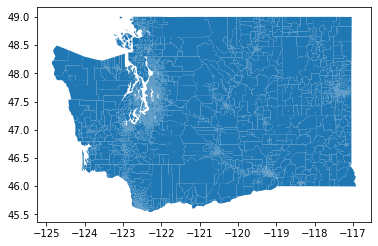

In [21]:
#Take a look
wa_shapefile.plot()

#Create a unique_ID
wa_shapefile["unique_ID"] = wa_shapefile["St_Code"]

In [22]:
#Perform the join
source_join_one = pd.merge(wa_shapefile,election_results_pivot,on="unique_ID",how="outer",validate="1:1",indicator=True)
source_join_one["_merge"].value_counts()

both          7433
left_only       31
right_only       3
Name: _merge, dtype: int64

In [23]:
#Include the 31 left_only columns in the final check against VEST (they will have 0 votes)
source_join_one = source_join_one[source_join_one["_merge"].isin(["both","left_only"])]
for i in data_columns:
    source_join_one[i] =source_join_one[i].fillna(0)

## Final Merge

Note: There are two precincts we were unable to validate do to geometry issues, those are filtered out with the line "(i!=1037 and i!=7396)" in the code below

In [24]:
final_merge = pd.merge(vest_wa_20,source_join_one,on="unique_ID",how="outer",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          7464
left_only        0
right_only       0
Name: final_merge, dtype: int64

In [25]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_wa_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_wa_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)

1) For SK00000108 difference in area is 3.4790265351160756
2) For SK00000121 difference in area is 3.2734254131993556
3) For MA00000308 difference in area is 1.6926647826726917
4) For SK00000122 difference in area is 5.55942343566784
5) For MA00000309 difference in area is 0.32925717502341756
6) For SK00000201 difference in area is 0.5215313968840695
7) For IS00000252 difference in area is 2.8785615706133285
8) For IS00000155 difference in area is 7.183719422627448
9) For SK00000146 difference in area is 4.25852834918473
10) For SK00000223 difference in area is 0.2016379776677979
11) For IS00000209 difference in area is 1.3519970737496843
12) For IS00000354 difference in area is 0.4314903973977738
13) For IS00000153 difference in area is 0.4027571908873766
14) For IS00000151 difference in area is 8.184903239360692
15) For IS00000254 difference in area is 2.55716285986025
16) For IS00000154 difference in area is 4.081194698606545
17) For SK00000174 difference in area is 1.96432810447437

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


24) For CM00000252 difference in area is 94.50691169874102
25) For IS00000301 difference in area is 3.424928492980705
26) For SK00000204 difference in area is 0.423687050171635
27) For SK00000127 difference in area is 33.343900736355906
28) For IS00000162 difference in area is 1.2386178111554114
29) For IS00000310 difference in area is 3.997809578091196
30) For IS00000304 difference in area is 0.5086095361815373
31) For IS00000311 difference in area is 8.611850282786794
32) For IS00000309 difference in area is 4.1031112511670225
33) For SK00000158 difference in area is 10.006070421775734
34) For SK00000135 difference in area is 2.5389945818053996
35) For SK00000149 difference in area is 0.24320137730246197
36) For CM00000262 difference in area is 18.564662305674798
37) For SK00000119 difference in area is 1.1255287283151156
38) For CM00000215 difference in area is 136.87688738051435
39) For IS00000302 difference in area is 2.4542119180866906
40) For SK00000150 difference in area is 3.8

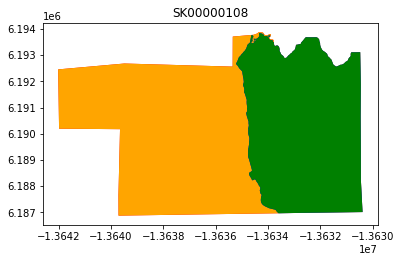

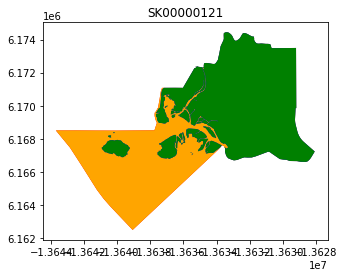

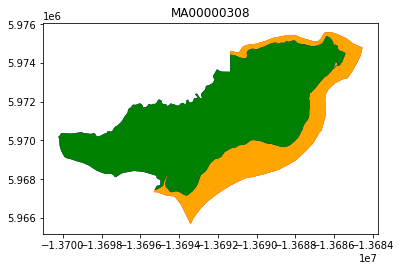

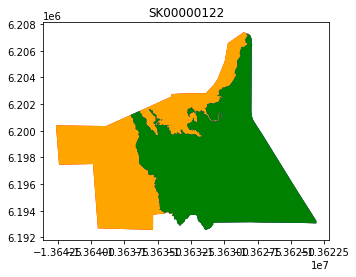

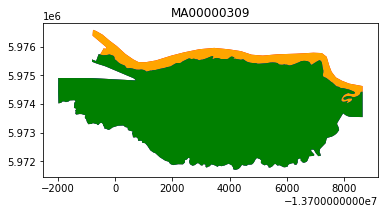

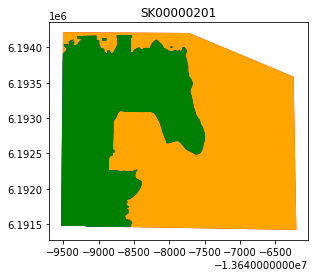

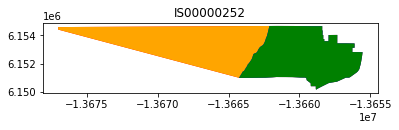

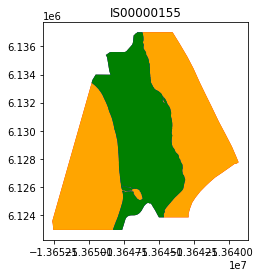

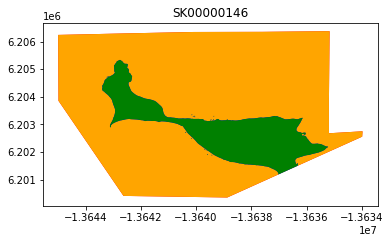

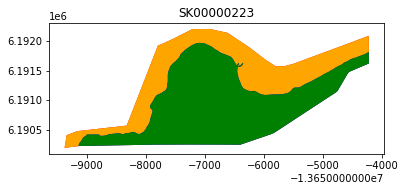

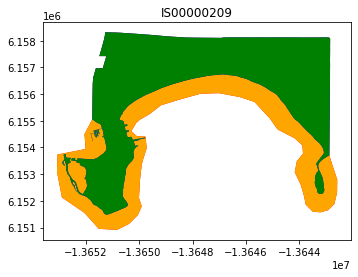

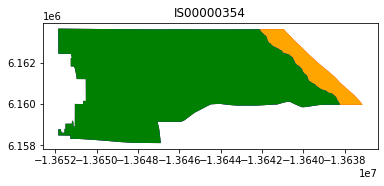

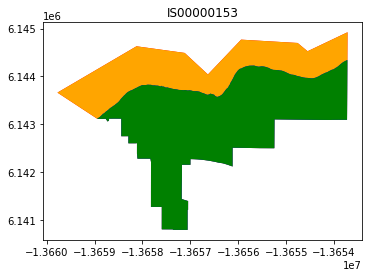

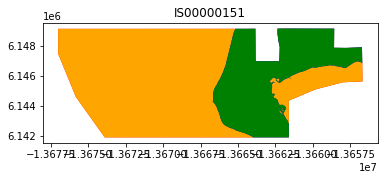

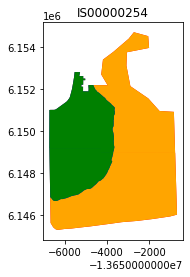

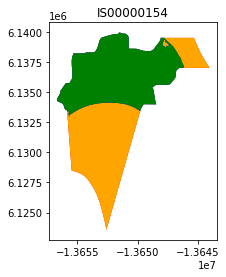

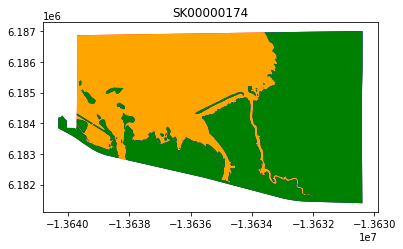

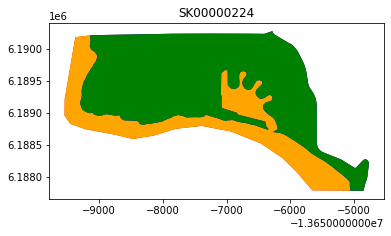

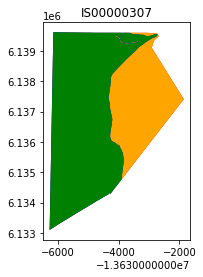

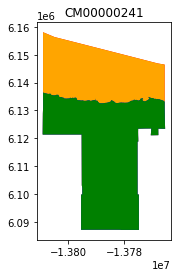

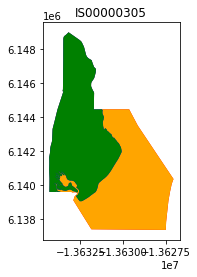

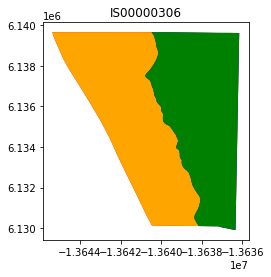

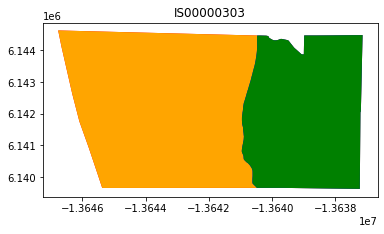

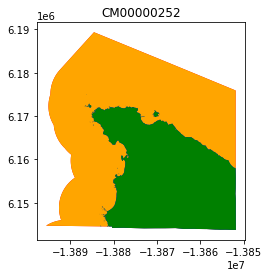

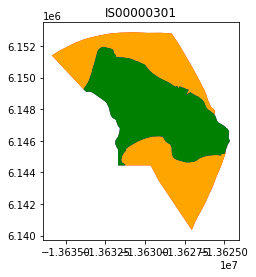

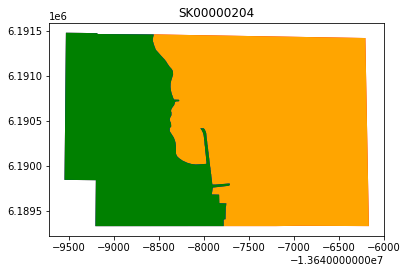

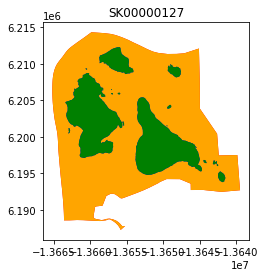

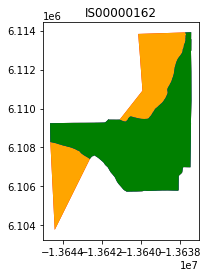

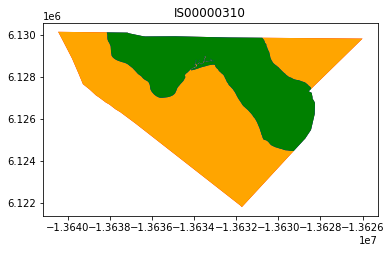

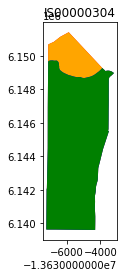

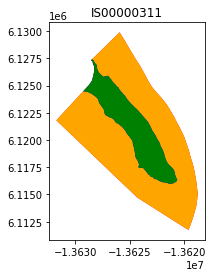

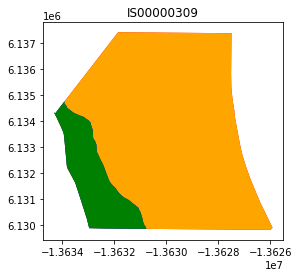

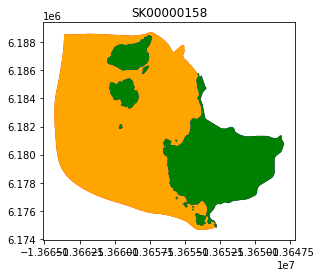

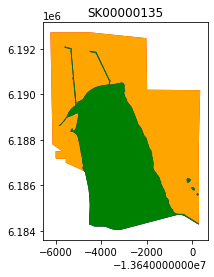

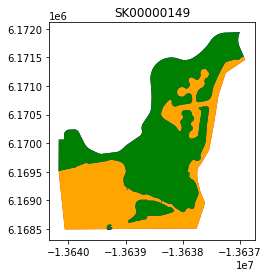

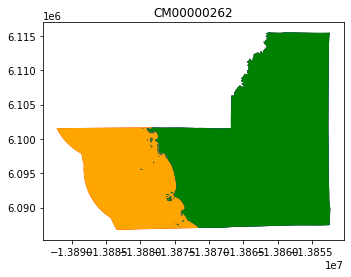

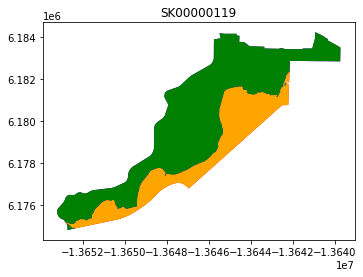

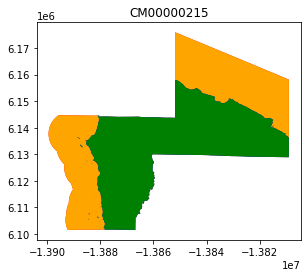

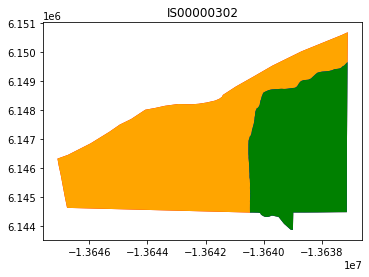

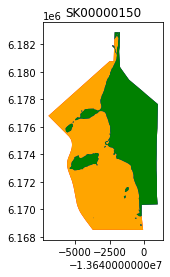

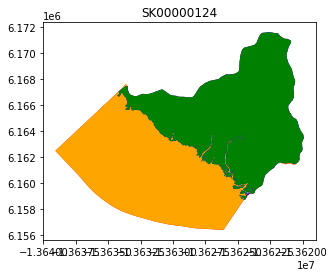

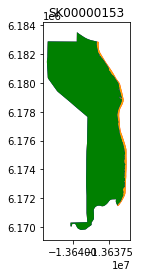

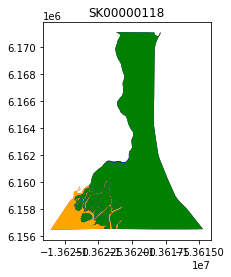

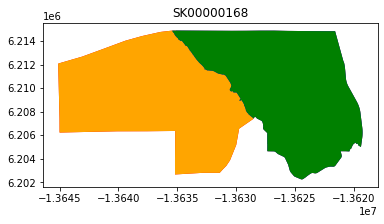

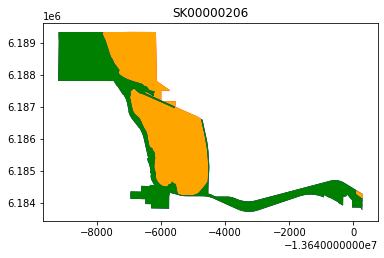

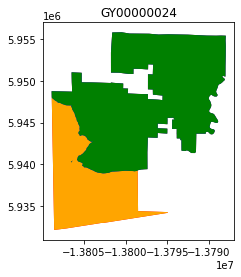

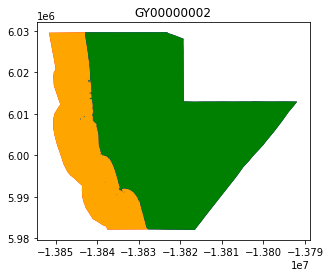

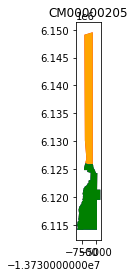

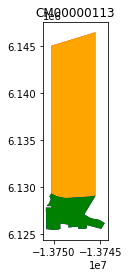

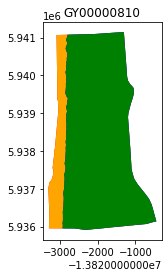

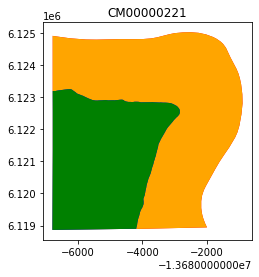

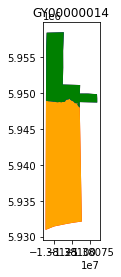

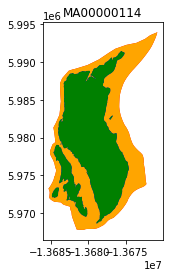

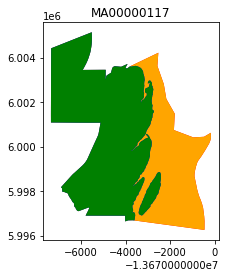

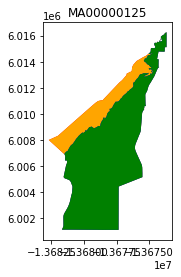

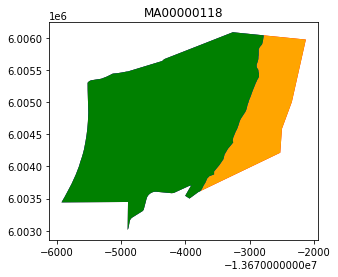

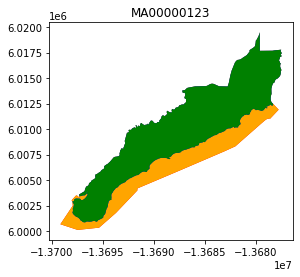

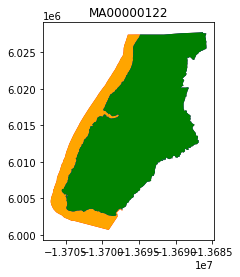

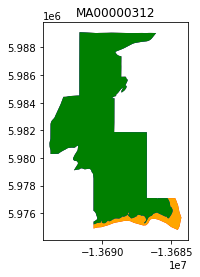

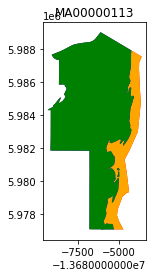

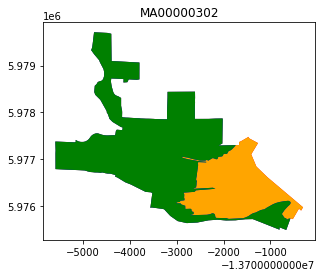

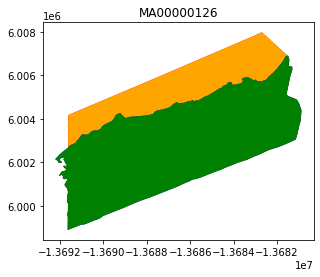

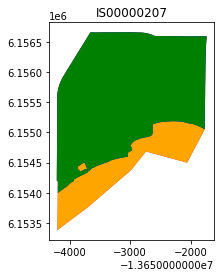

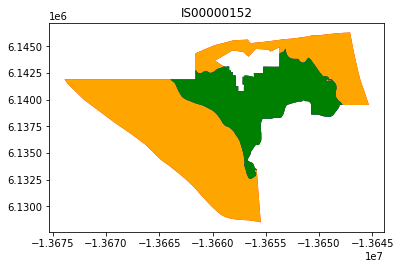

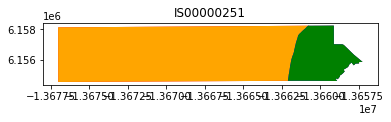

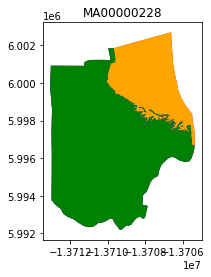

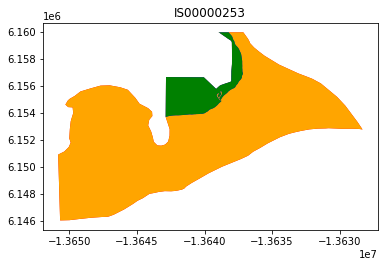

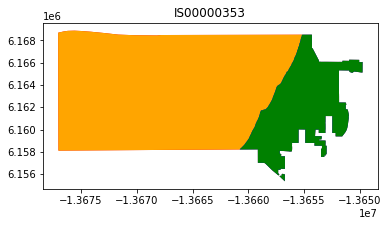

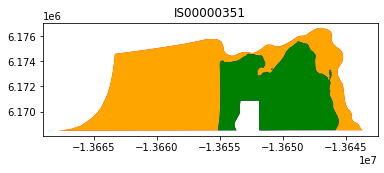

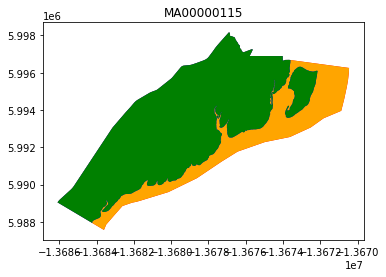

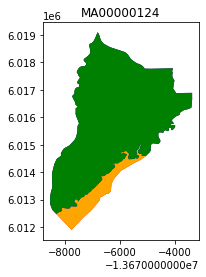

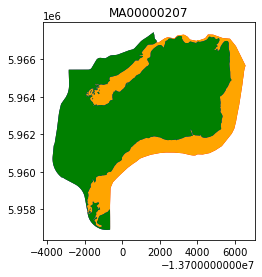

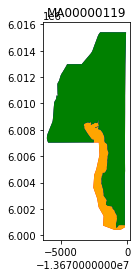

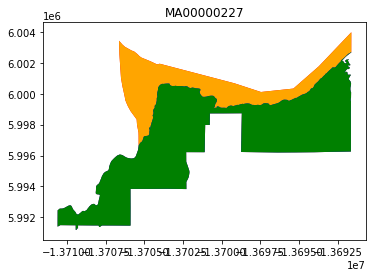

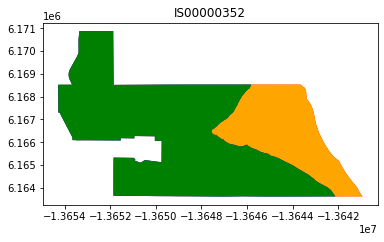

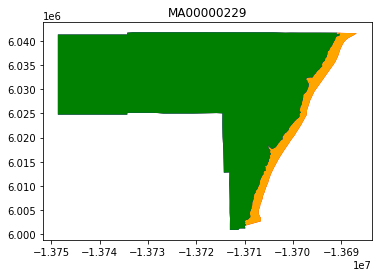

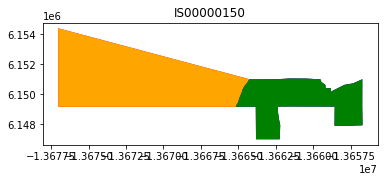

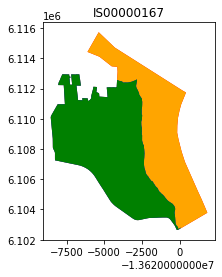

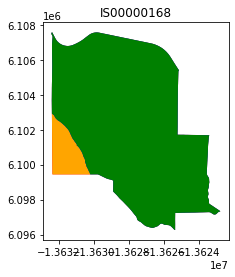

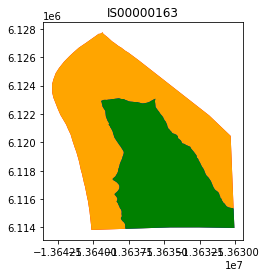

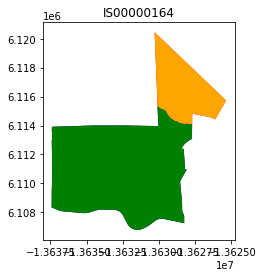

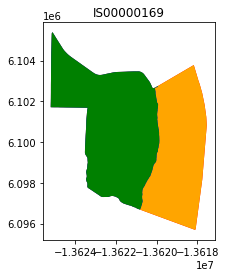

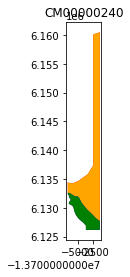

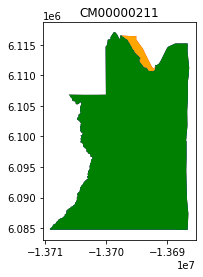

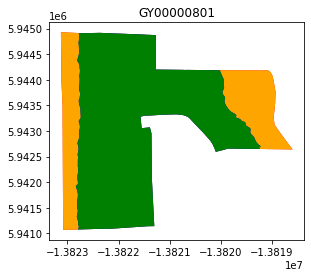

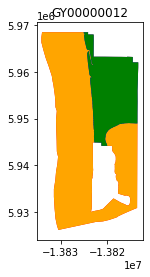

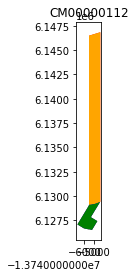

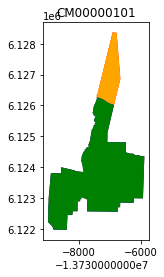

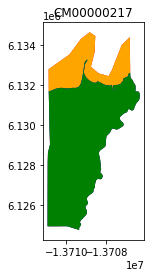

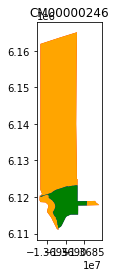

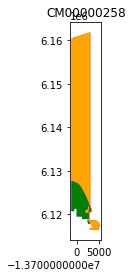

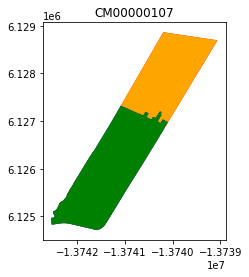

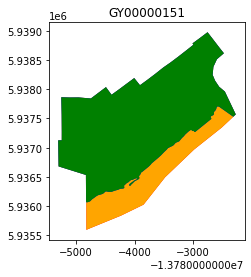

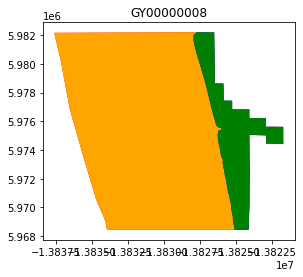

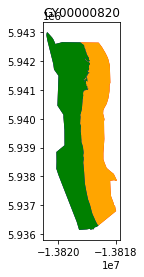

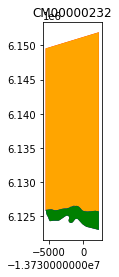

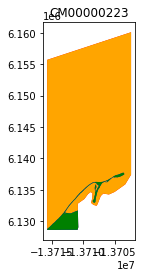

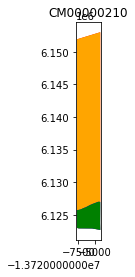

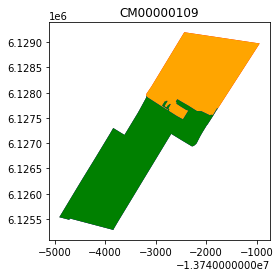

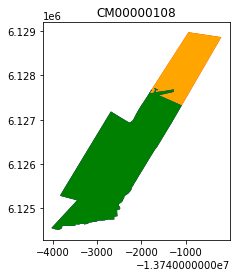

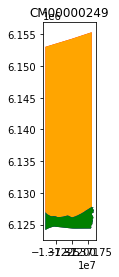

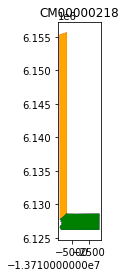

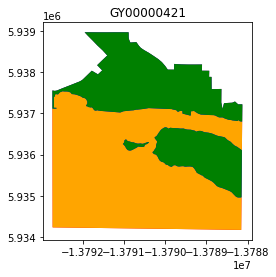

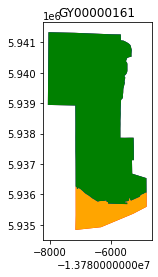

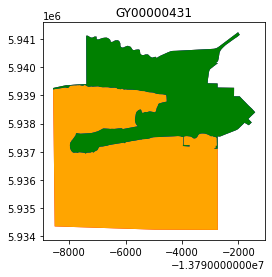

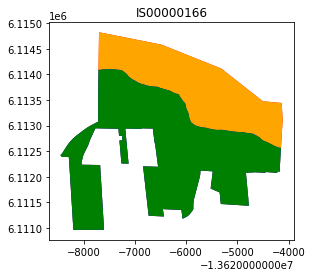

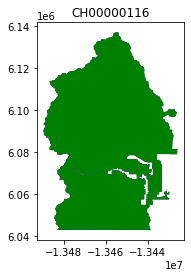

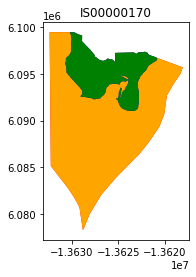

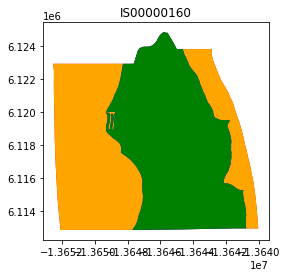

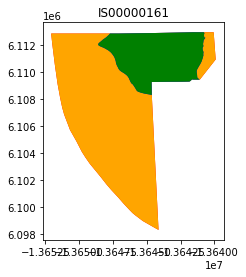

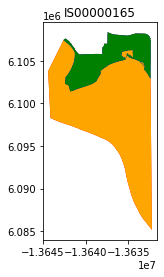

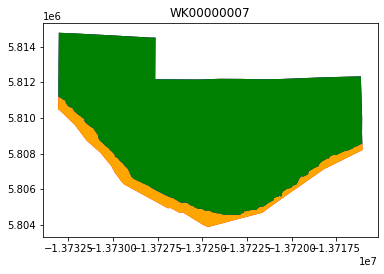

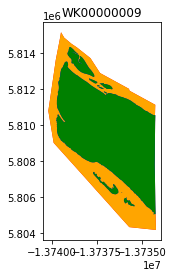

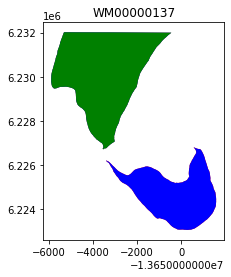

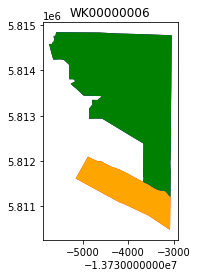

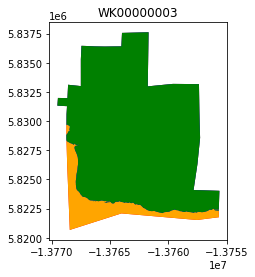

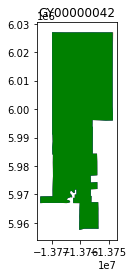

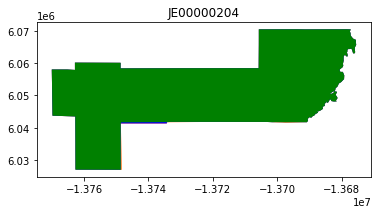

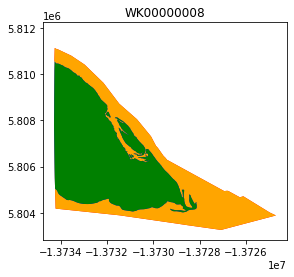

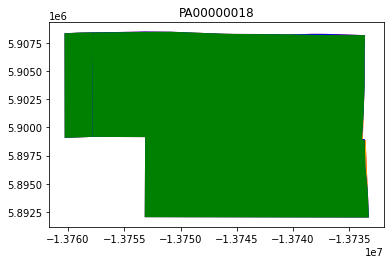

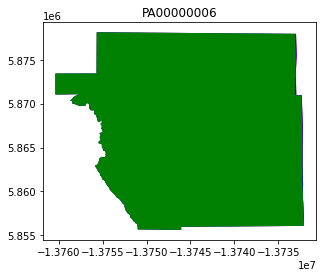

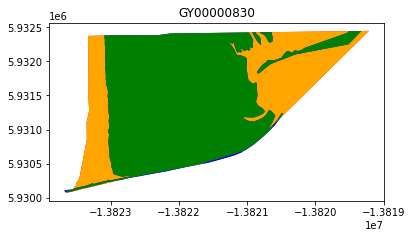

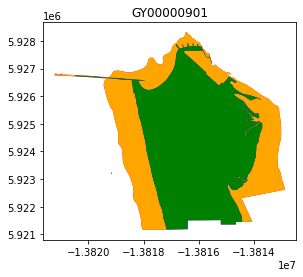

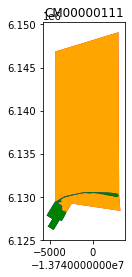

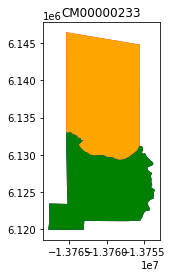

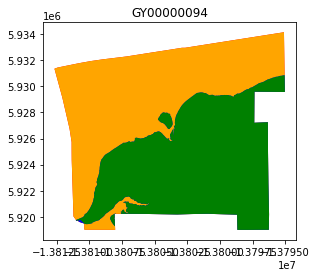

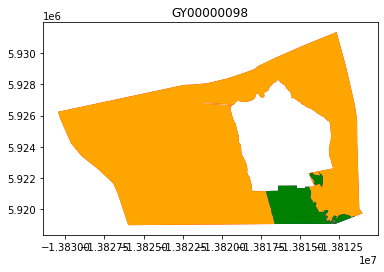

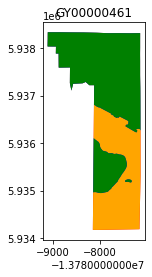

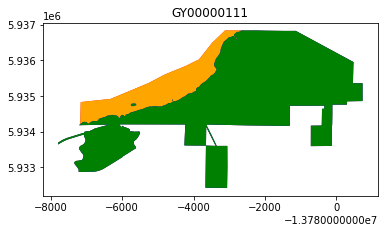

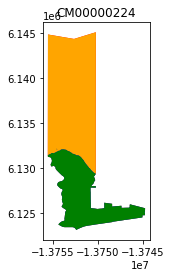

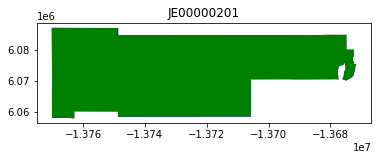

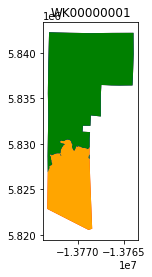

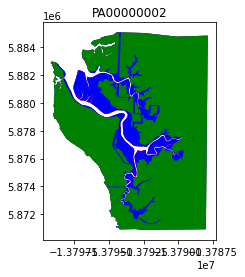

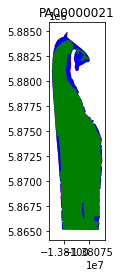

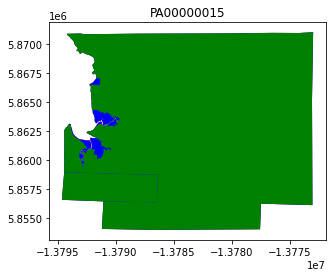

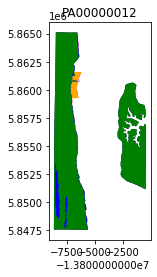

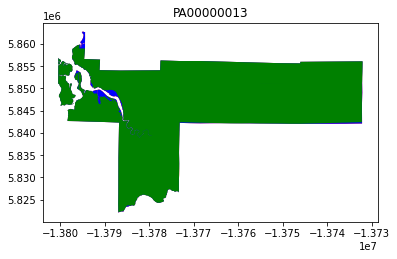

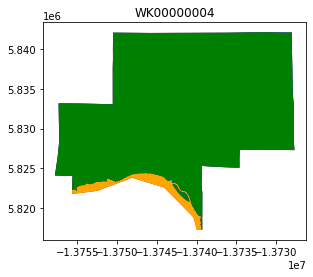

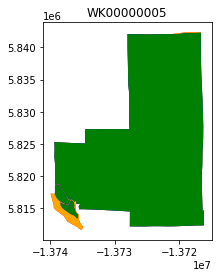

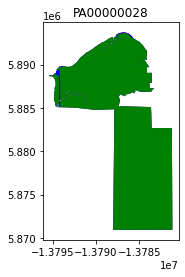

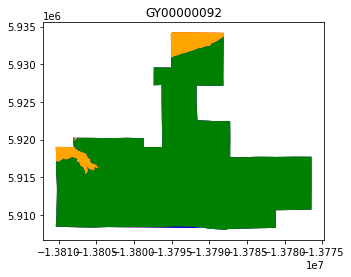

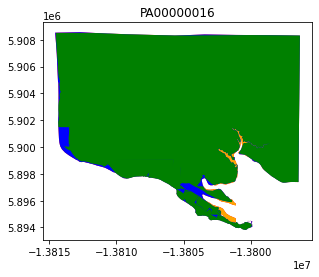

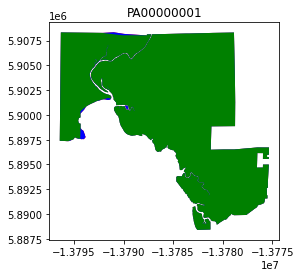

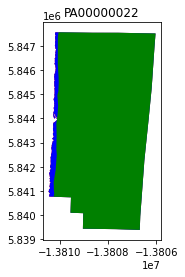

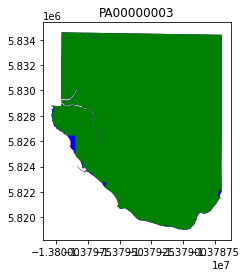

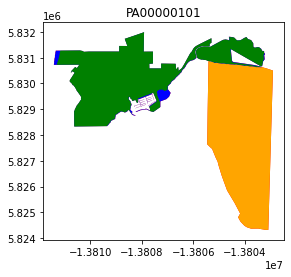

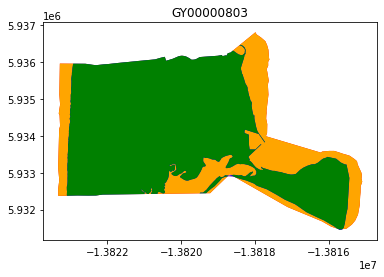

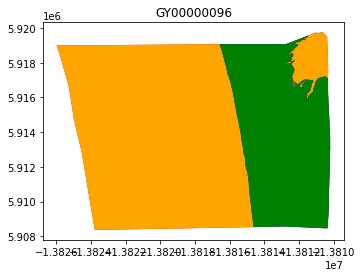

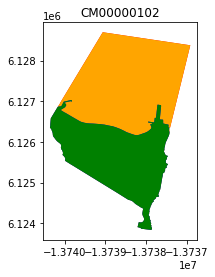

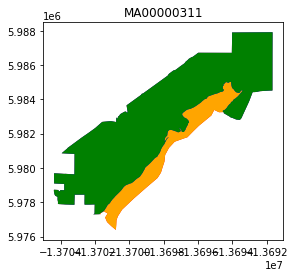

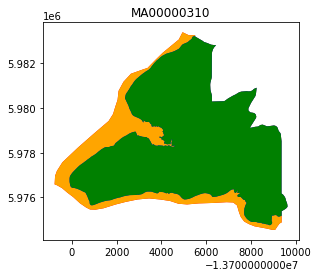

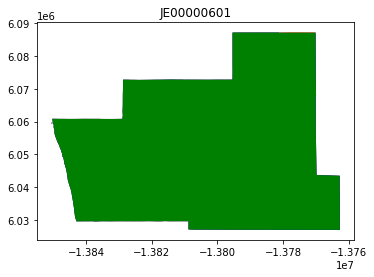

In [26]:
count = 0
area_list = []
diff_list = []
for i in range(0,len(source_geoms)):
    if (i!=1037 and i!=7396):
        diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
        intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
        area = float(diff.area/10e6)
        area_list.append(area)

        if (area > .1):
            count += 1
            name = source_geoms.iat[i,3]
            diff_list.append(name)
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                base.set_title(name)
            else:
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
print(diff_list)

In [27]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(7462, 1)
3003 precincts w/ a difference of 0 km^2
4307 precincts w/ a difference between 0 and .1 km^2
40 precincts w/ a difference between .1 and .5 km^2
19 precincts w/ a difference between .5 and 1 km^2
24 precincts w/ a difference between 1 and 2 km^2
25 precincts w/ a difference between 2 and 5 km^2
44 precincts w/ a difference greater than 5 km^2


In [28]:
#Define a list of the precincts with differences
diff_list = ['SK00000108', 'SK00000121', 'MA00000308', 'SK00000122', 'MA00000309', 'SK00000201', 'IS00000252', 'IS00000155', 'SK00000146', 'SK00000223', 'IS00000209', 'IS00000354', 'IS00000153', 'IS00000151', 'IS00000254', 'IS00000154', 'SK00000174', 'SK00000224', 'IS00000307', 'CM00000241', 'IS00000305', 'IS00000306', 'IS00000303', 'CM00000252', 'IS00000301', 'SK00000204', 'SK00000127', 'IS00000162', 'IS00000310', 'IS00000304', 'IS00000311', 'IS00000309', 'SK00000158', 'SK00000135', 'SK00000149', 'CM00000262', 'SK00000119', 'CM00000215', 'IS00000302', 'SK00000150', 'SK00000124', 'SK00000153', 'SK00000118', 'SK00000168', 'SK00000206', 'GY00000024', 'GY00000002', 'CM00000205', 'CM00000113', 'GY00000810', 'CM00000221', 'GY00000014', 'MA00000114', 'MA00000117', 'MA00000125', 'MA00000118', 'MA00000123', 'MA00000122', 'MA00000312', 'MA00000113', 'MA00000302', 'MA00000126', 'IS00000207', 'IS00000152', 'IS00000251', 'MA00000228', 'IS00000253', 'IS00000353', 'IS00000351', 'MA00000115', 'MA00000124', 'MA00000207', 'MA00000119', 'MA00000227', 'IS00000352', 'MA00000229', 'IS00000150', 'IS00000167', 'IS00000168', 'IS00000163', 'IS00000164', 'IS00000169', 'CM00000240', 'CM00000211', 'GY00000801', 'GY00000012', 'CM00000112', 'CM00000101', 'CM00000217', 'CM00000246', 'CM00000258', 'CM00000107', 'GY00000151', 'GY00000008', 'GY00000820', 'CM00000232', 'CM00000223', 'CM00000210', 'CM00000109', 'CM00000108', 'CM00000249', 'CM00000218', 'GY00000421', 'GY00000161', 'GY00000431', 'IS00000166', 'CH00000116', 'IS00000170', 'IS00000160', 'IS00000161', 'IS00000165', 'WK00000007', 'WK00000009', 'WM00000137', 'WK00000006', 'WK00000003', 'GY00000042', 'JE00000204', 'WK00000008', 'PA00000018', 'PA00000006', 'GY00000830', 'GY00000901', 'CM00000111', 'CM00000233', 'GY00000094', 'GY00000098', 'GY00000461', 'GY00000111', 'CM00000224', 'JE00000201', 'WK00000001', 'PA00000002', 'PA00000021', 'PA00000015', 'PA00000012', 'PA00000013', 'WK00000004', 'WK00000005', 'PA00000028', 'GY00000092', 'PA00000016', 'PA00000001', 'PA00000022', 'PA00000003', 'PA00000101', 'GY00000803', 'GY00000096', 'CM00000102', 'MA00000311', 'MA00000310', 'JE00000601']

<AxesSubplot:>

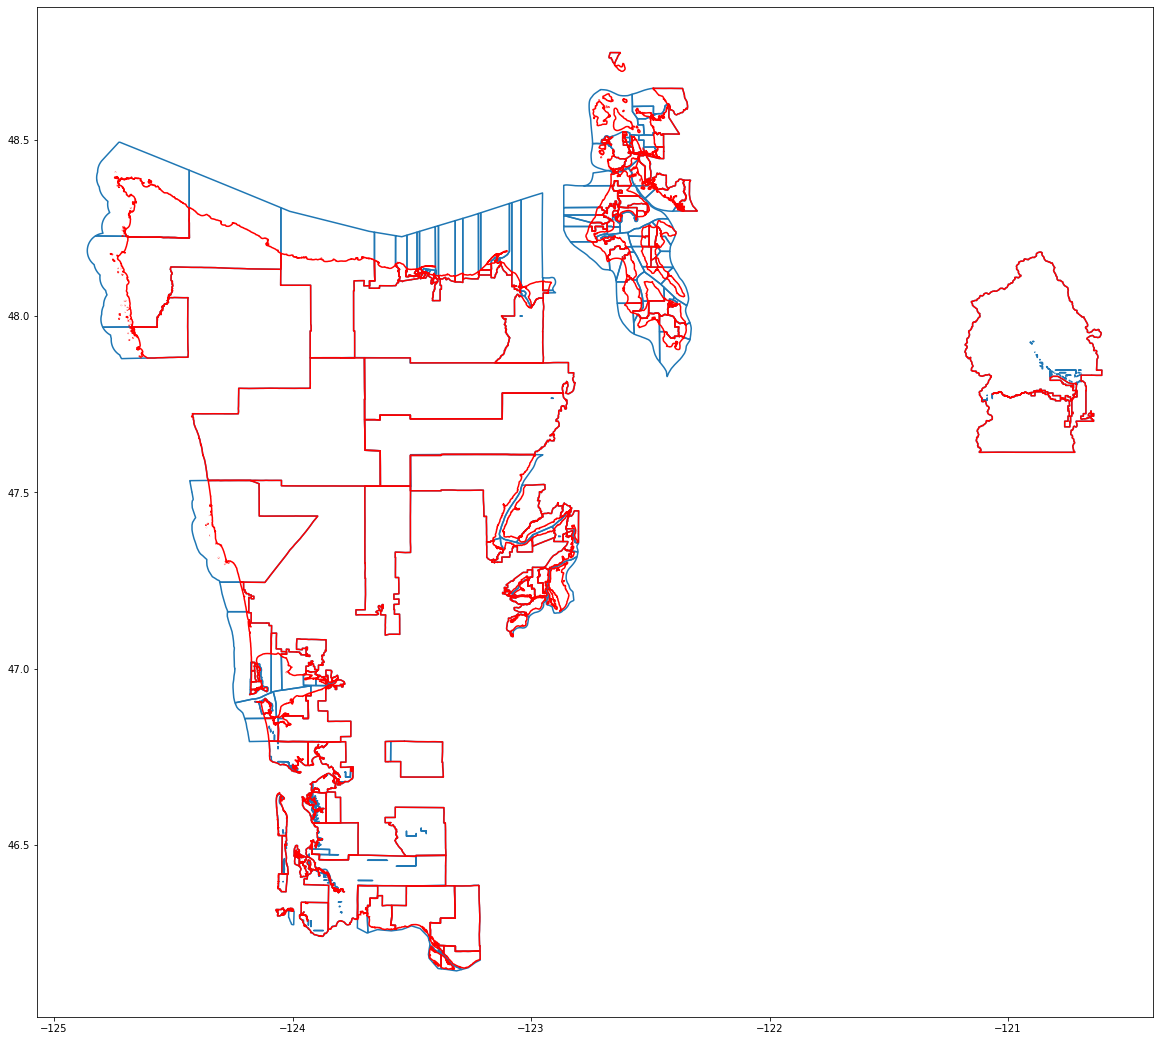

In [29]:
ax= source_join_one[source_join_one["unique_ID"].isin(diff_list)].boundary.plot(figsize=(20,20))
vest_wa_20[vest_wa_20["unique_ID"].isin(diff_list)].boundary.plot(color="red",ax=ax)

All the differences appear to be due to water boundaries, it is likely that VEST clipped their file with an official state map, as shown below

In [30]:
census_shapes = gp.read_file("./raw-from-source/Census_Maps/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")
census_shapes =census_shapes.to_crs(3857)
source_join_one=source_join_one.to_crs(3857)

In [31]:
clipped_map = gp.overlay(census_shapes,source_join_one,how="intersection")
clipped_map =clipped_map.to_crs(3857)
vest_wa_20 = vest_wa_20.to_crs(3857)

<AxesSubplot:>

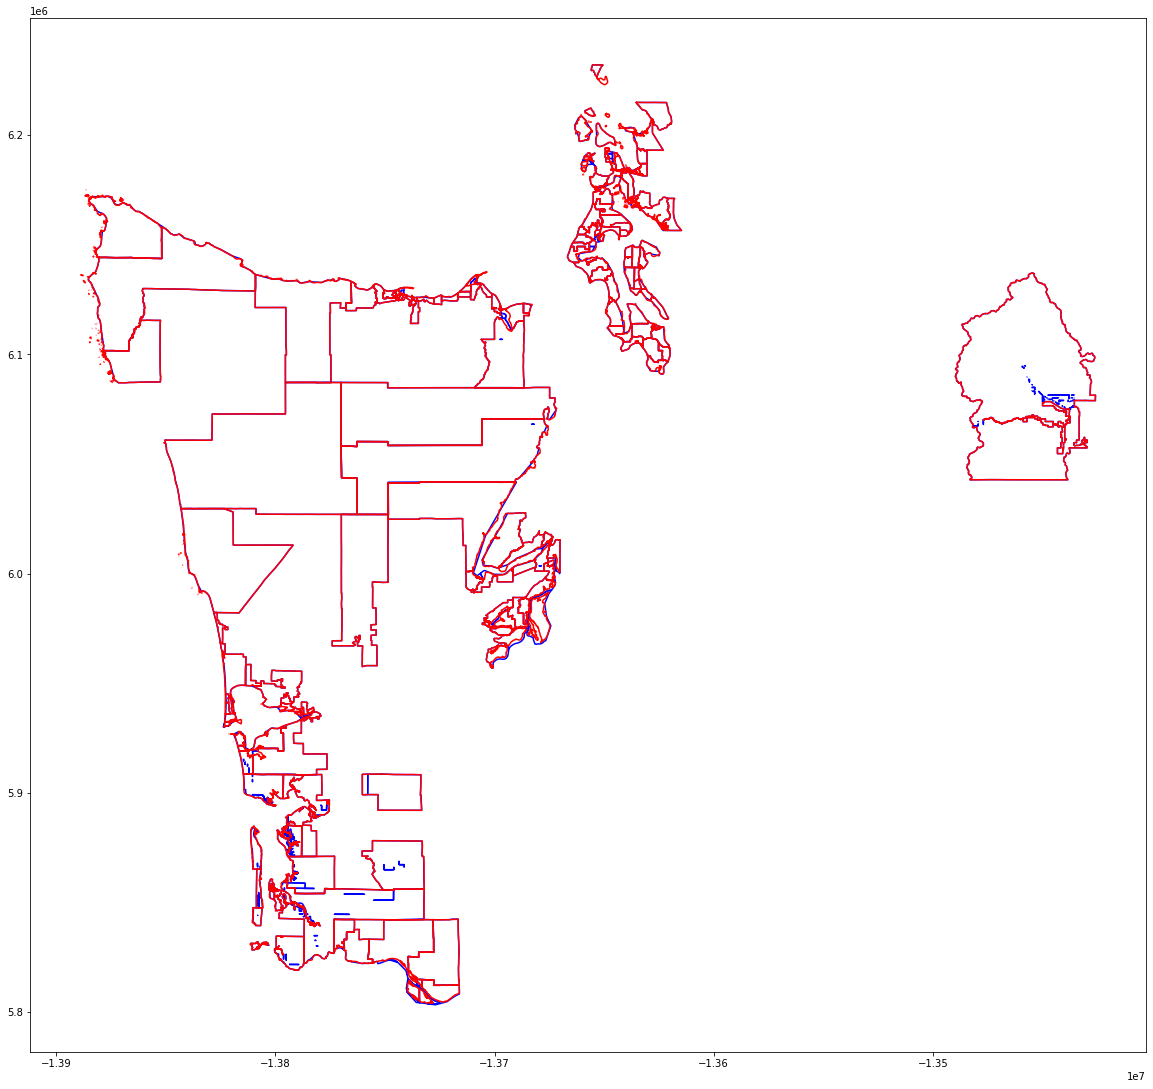

In [32]:
ax= clipped_map[clipped_map["unique_ID"].isin(diff_list)].boundary.plot(figsize=(20,20),color="blue")
vest_wa_20[vest_wa_20["unique_ID"].isin(diff_list)].boundary.plot(color="red",ax=ax)

In [33]:
#VEST seems to have clipped their file to the boundaries and the remaining differences appear minor